# CS 418: University Restaurant Dining Assessment
### By: Joseph Tamras, Tristan Maltizo, Zach Lavengco, Alexsander Bairez
### https://github.com/maltizo2/cs-418-at-uic

# Data

In [1]:
import pandas as pd
import numpy as np
import io, time, json
import requests
from bs4 import BeautifulSoup
import math 
from time import sleep
from colleges import *
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
with open('./yelp_api_key.txt', 'r') as f:
    api_key = f.read().replace('\n','')

In [3]:
def read_api_key(filepath):
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')

In [4]:
def location_search_params(api_key, location, radius, **kwargs):
    """
    Construct url, headers and url_params. Reference API docs (link above) to use the arguments
    """
    # What is the url endpoint for search?
    url = 'https://api.yelp.com/v3/businesses/search'
    # How is Authentication performed?
    headers = {'Authorization':f'Bearer {api_key}'}
    # SPACES in url is problematic. How should you handle location containing spaces?
    url_params = {'location': location, 'radius': radius}
    # Include keyword arguments in url_params
    url_params.update(**kwargs)
    
    return url, headers, url_params

In [5]:
api_key = "test_api_key_xyz"
location = "1200 W Harrison St, Chicago, IL 60607"
radius = 1609 # 1609.34 meters for every mile. Radius is an integer thus we round to the nearest integer.
url, headers, url_params = location_search_params(api_key, location, radius, offset=0, limit=50)
url, headers, url_params
# ('https://<hidden_url_check_search_endpoint_docs_to_get_answer>',
#  {'Authorization': 'Bearer test_api_key_xyz'},
#  {'location': 'Chicago', 'offset': 0, 'limit': 50})

('https://api.yelp.com/v3/businesses/search',
 {'Authorization': 'Bearer test_api_key_xyz'},
 {'location': '1200 W Harrison St, Chicago, IL 60607',
  'radius': 1609,
  'offset': 0,
  'limit': 50})

In [6]:
def api_get_request(url, headers, url_params):
    """
    Send a HTTP GET request and return a json response 
    
    Args:
        url (string): API endpoint url
        headers (dict): A python dictionary containing HTTP headers including Authentication to be sent
        url_params (dict): The parameters (required and optional) supported by endpoint
        
    Returns:
        results (json): response as json
    """
    http_method = 'GET'
    response = requests.request(http_method, url, headers=headers, params=url_params)
    return response.json()
    

def yelp_search(api_key, location, radius, offset=0):
    """
    Make an authenticated request to the Yelp API.

    Args:
        api_key (string): Your Yelp API Key for Authentication
        location (string): Business Location
        offset (int): param for pagination

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the location
        businesses (list): list of dicts representing each business
    """
    url, headers, url_params = location_search_params(api_key, location, radius, offset=0)
    response_json = api_get_request(url, headers, url_params)
    return response_json["total"], list(response_json["businesses"])

api_key = read_api_key('yelp_api_key.txt')
num_records, data = yelp_search(api_key, '1200 W Harrison St, Chicago, IL 60607', 1609)

In [7]:
def paginated_restaurant_search_requests(api_key, location, radius, total):
    """
    Returns a list of tuples (url, headers, url_params) for paginated search of all restaurants
    Args:
        api_key (string): Your Yelp API Key for Authentication
        location (string): Business Location
        total (int): Total number of items to be fetched
    Returns:
        results (list): list of tuple (url, headers, url_params)
    """
    limit = 10
    num_offsets = math.ceil(total/limit)
    results =[]
    for i in range(num_offsets):
        results.append(location_search_params(api_key, location, radius, offset = i*limit, limit = 10, categories = 'restaurants'))
    return results

api_key = "test_api_key_xyz"
location = "1200 W Harrison St, Chicago, IL 60607"
radius = 1609
all_restaurants_requests = paginated_restaurant_search_requests(api_key, location, radius,15)
all_restaurants_requests

[('https://api.yelp.com/v3/businesses/search',
  {'Authorization': 'Bearer test_api_key_xyz'},
  {'location': '1200 W Harrison St, Chicago, IL 60607',
   'radius': 1609,
   'offset': 0,
   'limit': 10,
   'categories': 'restaurants'}),
 ('https://api.yelp.com/v3/businesses/search',
  {'Authorization': 'Bearer test_api_key_xyz'},
  {'location': '1200 W Harrison St, Chicago, IL 60607',
   'radius': 1609,
   'offset': 10,
   'limit': 10,
   'categories': 'restaurants'})]

In [8]:
def all_restaurants(api_key, location, radius):
    """
    Construct the pagination requests for ALL the restaurants on Yelp for a given location.

    Args:
        api_key (string): Your Yelp API Key for Authentication
        location (string): Business Location

    Returns:
        results (list): list of dicts representing each restaurant
    """
    # What keyword arguments should you pass to get first page of restaurants in Yelp
    url, headers, url_params = location_search_params(api_key, location, radius, offset=0, limit=10)
    response_json = api_get_request(url, headers, url_params)
    total_items = response_json["total"]
    
    all_restaurants_request = paginated_restaurant_search_requests(api_key, location, radius, total_items)
    
    # Use returned list of (url, headers, url_params) and function api_get_request to retrive all restaurants
    # REMEMBER to pause slightly after each request.
    data = []
    for req in all_restaurants_request:
        url, headers, url_params = req
        response_json = api_get_request(url, headers, url_params)
        try:
            data.extend(list(response_json['businesses']))
        except:
            continue
        sleep(0.2)
    return data

### Example data from one location

In [9]:
api_key = read_api_key('yelp_api_key.txt')
uic_data = all_restaurants(api_key, '1200 W Harrison St, Chicago, IL 60607', 1609)


### Get Name and Rating of all Restaurants Within 1 Mile Radius for 1 Location

In [10]:
uic_restaurants = []
uic_unique_categories = set()
uic_categories = []
ind = 0

priceMapping = {
    '$': 1,
    '$$': 2,
    '$$$': 3,
    '$$$$': 4,
}

for link in uic_data:
    no_price = 0
    try:
        price = link['price']
        dict = {
            "name": link['name'],
            "rating": link['rating'],
            "price": priceMapping[price],
            "reviews": link['review_count'],
            "distance": round(link['distance']),
            "transactions": link['transactions'],
            "categories": link['categories']
        }
    except:
        dict = {
            "name": link['name'],
            "rating": link['rating'],
            "reviews": link['review_count'],
            "distance": round(link['distance']),
            "transactions": link['transactions'],
            "categories": link['categories']
        }
        no_price+=1
    uic_restaurants.append(dict)

    for c in dict['categories']:
        uic_unique_categories.add(c['alias'])

uic_unique_categories = len(uic_unique_categories)
uic_avg_rating = round(sum(d['rating'] for d in uic_restaurants) / len(uic_restaurants), 2)
uic_avg_reviews = round(sum(d['reviews'] for d in uic_restaurants) / len(uic_restaurants))
uic_avg_distance = round(sum(d['distance'] for d in uic_restaurants) / len(uic_restaurants))
sum_prices = 0
for d in uic_restaurants:
    if 'price' in d:
        sum_prices += d['price']
uic_avg_price = round(sum_prices) / (len(uic_restaurants)-no_price)

print(uic_avg_rating)
print(uic_avg_reviews)
print(uic_avg_distance)
print(uic_avg_price)
print(uic_unique_categories)

3.71
345
1110
1.431438127090301
107


## Retrieve restaurant data for 100 locations

### Notes:
Import college list containing pairs of (collegename, location) for the top 100 biggest colleges by enrollment<br />
Loop through each pair in the list and extract yelp dataset for each location<br />
Attach dataset to a dictionary containing sets of (key: collegename, values: {location, restaurantdata})<br />
Use this dictionary to pull college campus food statistics<br />
Make a visualization<br /><br />
ML application?

OTHER IDEAS:<br />
    # Finding health related words within restaurant reviews (using NLP)<br />
        # Implement by taking a dictionary of healthy words and checking if they exist in the review<br />
    # Rate food diversity by category: https://www.yelp.com/developers/documentation/v3/all_category_list<br />
    # See differences in rating, reviews, location for each university<br />
    # Check popularity rating by using "review count" (aggregate)<br />
        # can check most popular restaurants between all campuses<br />
    # "distance" and "transactions" can be used to determine availability rating<br />
    # "total" used to compare amount of options<br />
    # "price" to check affordability<br />
        # NOTE: price doesn't work with current function, will need to get the ids from each restaurant and use this: https://www.yelp.com/developers/documentation/v3/business<br />

In [112]:
### All data came from top_100_addresses.ipynb ###

# Import college list containing pairs of (collegename, location) for the top 100 biggest colleges by enrollment
college_names = ['Southern New Hampshire University',
 'Western Governors University',
 'The Pennsylvania State University',
 'University of Phoenix-Arizona',
 'Arizona State University Campus Immersion',
 'Grand Canyon University',
 'University of Central Florida',
 'Texas A & M University-College Station',
 'Ivy Tech Community College',
 'Lone Star College System',
 'Houston Community College',
 'Liberty University',
 'Dallas College',
 'Ohio State University-Main Campus',
 'University of Maryland Global Campus',
 'Brigham Young University-Idaho',
 'Tarrant County College District',
 'Miami Dade College',
 'Florida International University',
 'Arizona State University Digital Immersion',
 'The University of Texas at Austin',
 'Eastern Gateway Community College',
 'American Public University System',
 'Michigan State University',
 'University of Houston',
 'University of South Florida',
 'Valencia College',
 'California State University-Fullerton',
 'Kennesaw State University',
 'Northern Virginia Community College',
 'Purdue University-Main Campus',
 'Rutgers University-New Brunswick',
 'California State University-Northridge',
 'The University of Texas at Arlington',
 'University of Arizona',
 'University of Florida',
 'California State University-Long Beach',
 'Brigham Young University',
 'Texas State University',
 'University of Illinois Urbana-Champaign',
 'University of North Texas',
 'Indiana University-Bloomington',
 'Texas Tech University',
 'Florida State University',
 'Purdue University Global',
 'University of California-San Diego',
 'University of Wisconsin-Madison',
 'University of California-Los Angeles',
 'San Diego State University',
 'University of Michigan-Ann Arbor',
 'University of Washington-Seattle Campus',
 'University of California-Davis',
 'University of Minnesota-Twin Cities',
 'University of California-Berkeley',
 'The University of Alabama',
 'University of Maryland-College Park',
 'Virginia Polytechnic Institute and State University',
 'University of Colorado Boulder',
 'University of Georgia',
 'University of California-Irvine',
 'East Los Angeles College',
 'California State University-Sacramento',
 'The University of Texas at San Antonio',
 'Austin Community College District',
 'Utah Valley University',
 'Georgia State University',
 'California State Polytechnic University-Pomona',
 'San Jose State University',
 'College of Southern Nevada',
 'University of Cincinnati-Main Campus',
 'New York University',
 'Broward College',
 'University of South Carolina-Columbia',
 'Temple University',
 'The University of Texas Rio Grande Valley',
 'Iowa State University',
 'George Mason University',
 'Oregon State University',
 'Mt San Antonio College',
 'El Paso Community College',
 'University of Nevada-Las Vegas',
 'Louisiana State University and Agricultural & Mechanical College',
 'Washington State University',
 'Northern Arizona University',
 'Ashford University',
 'North Carolina State University at Raleigh',
 'Collin County Community College District',
 'Colorado Technical University-Colorado Springs',
 'Florida Atlantic University',
 'Auburn University',
 'The University of Tennessee-Knoxville',
 'University of Massachusetts-Amherst',
 'University of North Carolina at Charlotte',
 'Santa Monica College',
 'University of Utah',
 'San Francisco State University',
 'Colorado State University-Fort Collins',
 'University of California-Santa Barbara',
 'San Jacinto Community College',
 'Pasadena City College']

# college addresses
college_list = ['2500 N River Rd, Manchester, NH 03106, USA', '4001 S 700 E #300, Millcreek, UT 84107, USA', 'State College, PA 16801, USA', '4035 S Riverpoint Pkwy, Phoenix, AZ 85040, USA', 'Tempe, AZ 85281, USA', '3300 W Camelback Rd, Phoenix, AZ 85017, USA', '4000 Central Florida Blvd, Orlando, FL 32816, USA', 'Administration Building, 400 Bizzell St, College Station, TX 77843, USA', '410 E Columbus Dr, East Chicago, IN 46312, USA', '4141 Victory Dr, Houston, TX 77088, USA', '1300 Holman St, Houston, TX 77004, USA', '1971 University Blvd, Lynchburg, VA 24515, USA', '1601 Botham Jean Blvd, Dallas, TX 75215, USA', '281 W Lane Ave, Columbus, OH 43210, USA', '1616 McCormick Dr, Largo, MD 20774, USA', '525 S Center St, Rexburg, ID 83460, USA', '300 Trinity Campus Cir, Fort Worth, TX 76102, USA', '300 NE 2nd Ave, Miami, FL 33132, USA', '11200 SW 8th St, Miami, FL 33199, USA', '1365 N Scottsdale Rd, Scottsdale, AZ 85257, USA', 'Austin, TX 78712, USA', '4000 Sunset Blvd, Steubenville, OH 43952, USA', '111 W Congress St, Charles Town, WV 25414, USA', 'Michigan, USA', '4800 Calhoun Rd, Houston, TX 77004, USA', '4202 E Fowler Ave, Tampa, FL 33620, USA', '1800 S Kirkman Rd, Orlando, FL 32811, USA', '800 N State College Blvd, Fullerton, CA 92831, USA', '1000 Chastain Rd NW, Kennesaw, GA 30144, USA', '8333 Little River Turnpike, Annandale, VA 22003, USA', '610 Purdue Mall, West Lafayette, IN 47907, USA', 'New Brunswick, NJ, USA', '18111 Nordhoff St, Northridge, CA 91330, USA', '701 S Nedderman Dr, Arlington, TX 76019, USA', 'Tucson, AZ 85721, USA', 'Gainesville, FL 32611, USA', '1250 Bellflower Blvd, Long Beach, CA 90840, USA', 'Provo, UT 84602, USA', '601 University Dr, San Marcos, TX 78666, USA', 'Champaign, IL, USA', '1155 Union Cir, Denton, TX 76203, USA', '107 S Indiana Ave, Bloomington, IN 47405, USA', '2500 Broadway, Lubbock, TX 79409, USA', '600 W College Ave, Tallahassee, FL 32306, USA', 'State Farm Insurance Company, 2550 Northwestern Ave Suite 1100, West Lafayette, IN 47906, USA', '9500 Gilman Dr, La Jolla, CA 92093, USA', 'Madison, WI, USA', 'Los Angeles, CA 90095, USA', '5500 Campanile Dr, San Diego, CA 92182, USA', '400 4th St, Ann Arbor, MI 48103, USA', 'Seattle, WA 98195, USA', '1 Shields Ave, Davis, CA 95616, USA', 'Minneapolis, MN 55455, USA', 'Berkeley, CA, USA', 'Tuscaloosa, AL 35487, USA', 'College Park, MD 20742, USA', 'Blacksburg, VA 24061, USA', 'Boulder, CO 80309, USA', 'Athens, GA 30602, USA', 'Irvine, CA 92697, USA', '1301 Avenida Cesar Chavez, Monterey Park, CA 91754, USA', '6000 Jed Smith Dr, Sacramento, CA 95819, USA', '1 UTSA Circle, San Antonio, TX 78249, USA', '11928 Stonehollow Dr, Austin, TX 78758, USA', '800 W University Pkwy, Orem, UT 84058, USA', 'Atlanta, GA 30302, USA', '3801 W Temple Ave, Pomona, CA 91768, USA', '1 Washington Sq, San Jose, CA 95192, USA', '700 College Dr, Henderson, NV 89002, USA', '2600 Clifton Ave, Cincinnati, OH 45221, USA', 'New York, NY 10012, USA', '4205 Bonaventure Blvd, Weston, FL 33332, USA', 'Columbia, SC 29208, USA', '1801 N Broad St, Philadelphia, PA 19122, USA', '1201 W University Dr, Edinburg, TX 78539, USA', 'Ames, IA 50011, USA', '4400 University Dr, Fairfax, VA 22030, USA', 'Corvallis, OR 97331, USA', '1100 N Grand Ave, Walnut, CA 91789, USA', '919 Hunter Dr, El Paso, TX 79915, USA', '4505 S Maryland Pkwy, Las Vegas, NV 89154, USA', 'Baton Rouge, LA 70803, USA', 'Pullman, WA, USA', 'S San Francisco St, Flagstaff, AZ 86011, USA', '180 S Arizona Ave Suite #301, Chandler, AZ 85225, USA', 'Raleigh, NC 27695, USA', '3452 Spur 399 W, McKinney, TX 75069, USA', '1575 Garden of the Gods Rd Suite 100, Colorado Springs, CO 80907, USA', '777 Glades Rd, Boca Raton, FL 33431, USA', 'Auburn, AL 36849, USA', 'Knoxville, TN 37996, USA', 'Amherst, MA 01003, USA', '9201 University City Blvd, Charlotte, NC 28223, USA', '1900 Pico Blvd, Santa Monica, CA 90405, USA', "201 Presidents' Cir, Salt Lake City, UT 84112, USA", '1600 Holloway Ave, San Francisco, CA 94132, USA', 'Fort Collins, CO 80523, USA', 'Santa Barbara, CA 93106, USA', '8060 Spencer Hwy, Pasadena, TX 77505, USA', '1570 E Colorado Blvd, Pasadena, CA 91106, USA']

# college names, population, address
colleges = [{'univ_name': 'Southern New Hampshire University', 'population': 109233, 'address': '2500 N River Rd, Manchester, NH 03106, USA'}, {'univ_name': 'Western Governors University', 'population': 104919, 'address': '4001 S 700 E #300, Millcreek, UT 84107, USA'}, {'univ_name': 'The Pennsylvania State University', 'population': 73189, 'address': 'State College, PA 16801, USA'}, {'univ_name': 'University of Phoenix-Arizona', 'population': 66294, 'address': '4035 S Riverpoint Pkwy, Phoenix, AZ 85040, USA'}, {'univ_name': 'Arizona State University Campus Immersion', 'population': 62633, 'address': 'Tempe, AZ 85281, USA'}, {'univ_name': 'Grand Canyon University', 'population': 62424, 'address': '3300 W Camelback Rd, Phoenix, AZ 85017, USA'}, {'univ_name': 'University of Central Florida', 'population': 61111, 'address': '4000 Central Florida Blvd, Orlando, FL 32816, USA'}, {'univ_name': 'Texas A & M University-College Station', 'population': 54942, 'address': 'Administration Building, 400 Bizzell St, College Station, TX 77843, USA'}, {'univ_name': 'Ivy Tech Community College', 'population': 50792, 'address': '410 E Columbus Dr, East Chicago, IN 46312, USA'}, {'univ_name': 'Lone Star College System', 'population': 50580, 'address': '4141 Victory Dr, Houston, TX 77088, USA'}, {'univ_name': 'Houston Community College', 'population': 48060, 'address': '1300 Holman St, Houston, TX 77004, USA'}, {'univ_name': 'Liberty University', 'population': 47432, 'address': '1971 University Blvd, Lynchburg, VA 24515, USA'}, {'univ_name': 'Dallas College', 'population': 45888, 'address': '1601 Botham Jean Blvd, Dallas, TX 75215, USA'}, {'univ_name': 'Ohio State University-Main Campus', 'population': 45862, 'address': '281 W Lane Ave, Columbus, OH 43210, USA'}, {'univ_name': 'University of Maryland Global Campus', 'population': 44442, 'address': '3501 University Blvd E, Adelphi, MD 20783, USA'}, {'univ_name': 'Brigham Young University-Idaho', 'population': 43660, 'address': '525 S Center St, Rexburg, ID 83460, USA'}, {'univ_name': 'Tarrant County College District', 'population': 41369, 'address': '300 Trinity Campus Cir, Fort Worth, TX 76102, USA'}, {'univ_name': 'Miami Dade College', 'population': 41353, 'address': '300 NE 2nd Ave, Miami, FL 33132, USA'}, {'univ_name': 'Florida International University', 'population': 41220, 'address': '11200 SW 8th St, Miami, FL 33199, USA'}, {'univ_name': 'Arizona State University Digital Immersion', 'population': 40275, 'address': '1365 N Scottsdale Rd, Scottsdale, AZ 85257, USA'}, {'univ_name': 'The University of Texas at Austin', 'population': 39624, 'address': 'Austin, TX 78712, USA'}, {'univ_name': 'Eastern Gateway Community College', 'population': 38613, 'address': '4000 Sunset Blvd, Steubenville, OH 43952, USA'}, {'univ_name': 'American Public University System', 'population': 38546, 'address': '111 W Congress St, Charles Town, WV 25414, USA'}, {'univ_name': 'Michigan State University', 'population': 38413, 'address': 'Michigan, USA'}, {'univ_name': 'University of Houston', 'population': 38116, 'address': '4800 Calhoun Rd, Houston, TX 77004, USA'}, {'univ_name': 'University of South Florida', 'population': 37002, 'address': '4202 E Fowler Ave, Tampa, FL 33620, USA'}, {'univ_name': 'Valencia College', 'population': 36915, 'address': '1800 S Kirkman Rd, Orlando, FL 32811, USA'}, {'univ_name': 'California State University-Fullerton', 'population': 36874, 'address': '800 N State College Blvd, Fullerton, CA 92831, USA'}, {'univ_name': 'Kennesaw State University', 'population': 36284, 'address': '1000 Chastain Rd NW, Kennesaw, GA 30144, USA'}, {'univ_name': 'Northern Virginia Community College', 'population': 35849, 'address': '8333 Little River Turnpike, Annandale, VA 22003, USA'}, {'univ_name': 'Purdue University-Main Campus', 'population': 35517, 'address': '610 Purdue Mall, West Lafayette, IN 47907, USA'}, {'univ_name': 'Rutgers University-New Brunswick', 'population': 35428, 'address': 'New Brunswick, NJ, USA'}, {'univ_name': 'California State University-Northridge', 'population': 34881, 'address': '18111 Nordhoff St, Northridge, CA 91330, USA'}, {'univ_name': 'The University of Texas at Arlington', 'population': 34726, 'address': '701 S Nedderman Dr, Arlington, TX 76019, USA'}, {'univ_name': 'University of Arizona', 'population': 34659, 'address': 'Tucson, AZ 85721, USA'}, {'univ_name': 'University of Florida', 'population': 34237, 'address': 'Gainesville, FL 32611, USA'}, {'univ_name': 'California State University-Long Beach', 'population': 34188, 'address': '1250 Bellflower Blvd, Long Beach, CA 90840, USA'}, {'univ_name': 'Brigham Young University', 'population': 33376, 'address': 'Provo, UT 84602, USA'}, {'univ_name': 'Texas State University', 'population': 33193, 'address': '601 University Dr, San Marcos, TX 78666, USA'}, {'univ_name': 'University of Illinois Urbana-Champaign', 'population': 33001, 'address': 'Champaign, IL, USA'}, {'univ_name': 'University of North Texas', 'population': 32814, 'address': '1155 Union Cir, Denton, TX 76203, USA'}, {'univ_name': 'Indiana University-Bloomington', 'population': 32621, 'address': '107 S Indiana Ave, Bloomington, IN 47405, USA'}, {'univ_name': 'Texas Tech University', 'population': 32412, 'address': '2500 Broadway, Lubbock, TX 79409, USA'}, {'univ_name': 'Florida State University', 'population': 32384, 'address': '600 W College Ave, Tallahassee, FL 32306, USA'}, {'univ_name': 'Purdue University Global', 'population': 32296, 'address': 'State Farm Insurance Company, 2550 Northwestern Ave Suite 1100, West Lafayette, IN 47906, USA'}, {'univ_name': 'University of California-San Diego', 'population': 31827, 'address': '9500 Gilman Dr, La Jolla, CA 92093, USA'}, {'univ_name': 'University of Wisconsin-Madison', 'population': 31651, 'address': 'Madison, WI, USA'}, {'univ_name': 'University of California-Los Angeles', 'population': 31636, 'address': 'Los Angeles, CA 90095, USA'}, {'univ_name': 'San Diego State University', 'population': 31293, 'address': '5500 Campanile Dr, San Diego, CA 92182, USA'}, {'univ_name': 'University of Michigan-Ann Arbor', 'population': 31189, 'address': '500 S State St, Ann Arbor, MI 48109, USA'}, {'univ_name': 'University of Washington-Seattle Campus', 'population': 31145, 'address': 'Seattle, WA 98195, USA'}, {'univ_name': 'University of California-Davis', 'population': 31142, 'address': '1 Shields Ave, Davis, CA 95616, USA'}, {'univ_name': 'University of Minnesota-Twin Cities', 'population': 30907, 'address': 'Minneapolis, MN 55455, USA'}, {'univ_name': 'University of California-Berkeley', 'population': 30796, 'address': 'Berkeley, CA, USA'}, {'univ_name': 'The University of Alabama', 'population': 30610, 'address': 'Tuscaloosa, AL 35487, USA'}, {'univ_name': 'University of Maryland-College Park', 'population': 30214, 'address': 'College Park, MD 20742, USA'}, {'univ_name': 'Virginia Polytechnic Institute and State University', 'population': 29893, 'address': 'Blacksburg, VA 24061, USA'}, {'univ_name': 'University of Colorado Boulder', 'population': 29779, 'address': 'Boulder, CO 80309, USA'}, {'univ_name': 'University of Georgia', 'population': 29705, 'address': 'Athens, GA 30602, USA'}, {'univ_name': 'University of California-Irvine', 'population': 29627, 'address': 'Irvine, CA 92697, USA'}, {'univ_name': 'East Los Angeles College', 'population': 29275, 'address': '1301 Avenida Cesar Chavez, Monterey Park, CA 91754, USA'}, {'univ_name': 'California State University-Sacramento', 'population': 29228, 'address': '6000 Jed Smith Dr, Sacramento, CA 95819, USA'}, {'univ_name': 'The University of Texas at San Antonio', 'population': 29169, 'address': '1 UTSA Circle, San Antonio, TX 78249, USA'}, {'univ_name': 'Austin Community College District', 'population': 28882, 'address': '11928 Stonehollow Dr, Austin, TX 78758, USA'}, {'univ_name': 'Utah Valley University', 'population': 28120, 'address': '800 W University Pkwy, Orem, UT 84058, USA'}, {'univ_name': 'Georgia State University', 'population': 28085, 'address': 'Atlanta, GA 30302, USA'}, {'univ_name': 'California State Polytechnic University-Pomona', 'population': 27862, 'address': '3801 W Temple Ave, Pomona, CA 91768, USA'}, {'univ_name': 'San Jose State University', 'population': 27614, 'address': '1 Washington Sq, San Jose, CA 95192, USA'}, {'univ_name': 'College of Southern Nevada', 'population': 27605, 'address': '700 College Dr, Henderson, NV 89002, USA'}, {'univ_name': 'University of Cincinnati-Main Campus', 'population': 27425, 'address': '2600 Clifton Ave, Cincinnati, OH 45221, USA'}, {'univ_name': 'New York University', 'population': 27276, 'address': 'New York, NY 10012, USA'}, {'univ_name': 'Broward College', 'population': 27128, 'address': '4205 Bonaventure Blvd, Weston, FL 33332, USA'}, {'univ_name': 'University of South Carolina-Columbia', 'population': 27053, 'address': 'Columbia, SC 29208, USA'}, {'univ_name': 'Temple University', 'population': 26969, 'address': '1801 N Broad St, Philadelphia, PA 19122, USA'}, {'univ_name': 'The University of Texas Rio Grande Valley', 'population': 26754, 'address': '1201 W University Dr, Edinburg, TX 78539, USA'}, {'univ_name': 'Iowa State University', 'population': 26566, 'address': 'Ames, IA 50011, USA'}, {'univ_name': 'George Mason University', 'population': 26514, 'address': '4400 University Dr, Fairfax, VA 22030, USA'}, {'univ_name': 'Oregon State University', 'population': 26048, 'address': 'Corvallis, OR 97331, USA'}, {'univ_name': 'Mt San Antonio College', 'population': 26037, 'address': '1100 N Grand Ave, Walnut, CA 91789, USA'}, {'univ_name': 'El Paso Community College', 'population': 25618, 'address': '919 Hunter Dr, El Paso, TX 79915, USA'}, {'univ_name': 'University of Nevada-Las Vegas', 'population': 25477, 'address': '4505 S Maryland Pkwy, Las Vegas, NV 89154, USA'}, {'univ_name': 'Louisiana State University and Agricultural & Mechanical College', 'population': 25203, 'address': 'Baton Rouge, LA 70803, USA'}, {'univ_name': 'Washington State University', 'population': 25084, 'address': 'Pullman, WA, USA'}, {'univ_name': 'Northern Arizona University', 'population': 24880, 'address': 'S San Francisco St, Flagstaff, AZ 86011, USA'}, {'univ_name': 'Ashford University', 'population': 24832, 'address': '180 S Arizona Ave Suite #301, Chandler, AZ 85225, USA'}, {'univ_name': 'North Carolina State University at Raleigh', 'population': 24671, 'address': 'Raleigh, NC 27695, USA'}, {'univ_name': 'Collin County Community College District', 'population': 24568, 'address': '3452 Spur 399 W, McKinney, TX 75069, USA'}, {'univ_name': 'Colorado Technical University-Colorado Springs', 'population': 24504, 'address': '1575 Garden of the Gods Rd Suite 100, Colorado Springs, CO 80907, USA'}, {'univ_name': 'Florida Atlantic University', 'population': 24396, 'address': '777 Glades Rd, Boca Raton, FL 33431, USA'}, {'univ_name': 'Auburn University', 'population': 24368, 'address': 'Auburn, AL 36849, USA'}, {'univ_name': 'The University of Tennessee-Knoxville', 'population': 24146, 'address': 'Knoxville, TN 37996, USA'}, {'univ_name': 'University of Massachusetts-Amherst', 'population': 23884, 'address': 'Amherst, MA 01003, USA'}, {'univ_name': 'University of North Carolina at Charlotte', 'population': 23852, 'address': '9201 University City Blvd, Charlotte, NC 28223, USA'}, {'univ_name': 'Santa Monica College', 'population': 23696, 'address': '1900 Pico Blvd, Santa Monica, CA 90405, USA'}, {'univ_name': 'University of Utah', 'population': 23645, 'address': "201 Presidents' Cir, Salt Lake City, UT 84112, USA"}, {'univ_name': 'San Francisco State University', 'population': 23411, 'address': '1600 Holloway Ave, San Francisco, CA 94132, USA'}, {'univ_name': 'Colorado State University-Fort Collins', 'population': 23332, 'address': 'Fort Collins, CO 80523, USA'}, {'univ_name': 'University of California-Santa Barbara', 'population': 23166, 'address': 'Santa Barbara, CA 93106, USA'}, {'univ_name': 'San Jacinto Community College', 'population': 23100, 'address': '8060 Spencer Hwy, Pasadena, TX 77505, USA'}, {'univ_name': 'Pasadena City College', 'population': 23035, 'address': '1570 E Colorado Blvd, Pasadena, CA 91106, USA'}]

# college names, population, avg_income
univ_data = [{'name': 'Southern New Hampshire University',
  'population': 109233,
  'avg_income': 37912},
 {'name': 'Western Governors University',
  'population': 104919,
  'avg_income': 54991},
 {'name': 'The Pennsylvania State University',
  'population': 73189,
  'avg_income': None},
 {'name': 'University of Phoenix-Arizona',
  'population': 66294,
  'avg_income': 25959},
 {'name': 'Arizona State University Campus Immersion',
  'population': 62633,
  'avg_income': 56365},
 {'name': 'Grand Canyon University', 'population': 62424, 'avg_income': 45046},
 {'name': 'University of Central Florida',
  'population': 61111,
  'avg_income': 47674},
 {'name': 'Texas A & M University-College Station',
  'population': 54942,
  'avg_income': 79762},
 {'name': 'Ivy Tech Community College',
  'population': 50792,
  'avg_income': 31666},
 {'name': 'Lone Star College System',
  'population': 50580,
  'avg_income': 30638},
 {'name': 'Houston Community College',
  'population': 48060,
  'avg_income': 25618},
 {'name': 'Liberty University', 'population': 47432, 'avg_income': 45801},
 {'name': 'Dallas College', 'population': 45888, 'avg_income': 23280},
 {'name': 'Ohio State University-Main Campus',
  'population': 45862,
  'avg_income': 80387},
 {'name': 'University of Maryland Global Campus',
  'population': 44442,
  'avg_income': 37491},
 {'name': 'Brigham Young University-Idaho',
  'population': 43660,
  'avg_income': 52778},
 {'name': 'Tarrant County College District',
  'population': 41369,
  'avg_income': 27573},
 {'name': 'Miami Dade College', 'population': 41353, 'avg_income': 22429},
 {'name': 'Florida International University',
  'population': 41220,
  'avg_income': 34024},
 {'name': 'Arizona State University Digital Immersion',
  'population': 40275,
  'avg_income': 56365},
 {'name': 'The University of Texas at Austin',
  'population': 39624,
  'avg_income': 75674},
 {'name': 'Eastern Gateway Community College',
  'population': 38613,
  'avg_income': 31646},
 {'name': 'American Public University System',
  'population': 38546,
  'avg_income': 27769},
 {'name': 'Michigan State University',
  'population': 38413,
  'avg_income': 89132},
 {'name': 'University of Houston', 'population': 38116, 'avg_income': 49662},
 {'name': 'University of South Florida',
  'population': 37002,
  'avg_income': 48536},
 {'name': 'Valencia College', 'population': 36915, 'avg_income': 30746},
 {'name': 'California State University-Fullerton',
  'population': 36874,
  'avg_income': 40804},
 {'name': 'Kennesaw State University',
  'population': 36284,
  'avg_income': 62194},
 {'name': 'Northern Virginia Community College',
  'population': 35849,
  'avg_income': 41328},
 {'name': 'Purdue University-Main Campus',
  'population': 35517,
  'avg_income': 98016},
 {'name': 'Rutgers University-New Brunswick',
  'population': 35428,
  'avg_income': 66613},
 {'name': 'California State University-Northridge',
  'population': 34881,
  'avg_income': 32895},
 {'name': 'The University of Texas at Arlington',
  'population': 34726,
  'avg_income': 48507},
 {'name': 'University of Arizona', 'population': 34659, 'avg_income': 69476},
 {'name': 'University of Florida', 'population': 34237, 'avg_income': 58287},
 {'name': 'California State University-Long Beach',
  'population': 34188,
  'avg_income': 38978},
 {'name': 'Brigham Young University',
  'population': 33376,
  'avg_income': 59069},
 {'name': 'Texas State University', 'population': 33193, 'avg_income': 61131},
 {'name': 'University of Illinois Urbana-Champaign',
  'population': 33001,
  'avg_income': 86138},
 {'name': 'University of North Texas',
  'population': 32814,
  'avg_income': 58313},
 {'name': 'Indiana University-Bloomington',
  'population': 32621,
  'avg_income': 98551},
 {'name': 'Texas Tech University', 'population': 32412, 'avg_income': 72431},
 {'name': 'Florida State University',
  'population': 32384,
  'avg_income': 66692},
 {'name': 'Purdue University Global',
  'population': 32296,
  'avg_income': 25167},
 {'name': 'University of California-San Diego',
  'population': 31827,
  'avg_income': 53756},
 {'name': 'University of Wisconsin-Madison',
  'population': 31651,
  'avg_income': 106025},
 {'name': 'University of California-Los Angeles',
  'population': 31636,
  'avg_income': 54617},
 {'name': 'San Diego State University',
  'population': 31293,
  'avg_income': 53802},
 {'name': 'University of Michigan-Ann Arbor',
  'population': 31189,
  'avg_income': 93277},
 {'name': 'University of Washington-Seattle Campus',
  'population': 31145,
  'avg_income': 60177},
 {'name': 'University of California-Davis',
  'population': 31142,
  'avg_income': 51677},
 {'name': 'University of Minnesota-Twin Cities',
  'population': 30907,
  'avg_income': 91158},
 {'name': 'University of California-Berkeley',
  'population': 30796,
  'avg_income': 54799},
 {'name': 'The University of Alabama',
  'population': 30610,
  'avg_income': 91846},
 {'name': 'University of Maryland-College Park',
  'population': 30214,
  'avg_income': 91754},
 {'name': 'Virginia Polytechnic Institute and State University',
  'population': 29893,
  'avg_income': 104698},
 {'name': 'University of Colorado Boulder',
  'population': 29779,
  'avg_income': 98821},
 {'name': 'University of Georgia', 'population': 29705, 'avg_income': 83743},
 {'name': 'University of California-Irvine',
  'population': 29627,
  'avg_income': 48922},
 {'name': 'East Los Angeles College',
  'population': 29275,
  'avg_income': 20518},
 {'name': 'California State University-Sacramento',
  'population': 29228,
  'avg_income': 39578},
 {'name': 'The University of Texas at San Antonio',
  'population': 29169,
  'avg_income': 52852},
 {'name': 'Austin Community College District',
  'population': 28882,
  'avg_income': 34292},
 {'name': 'Utah Valley University', 'population': 28120, 'avg_income': 46899},
 {'name': 'Georgia State University',
  'population': 28085,
  'avg_income': 41486},
 {'name': 'California State Polytechnic University-Pomona',
  'population': 27862,
  'avg_income': 43622},
 {'name': 'San Jose State University',
  'population': 27614,
  'avg_income': 44094},
 {'name': 'College of Southern Nevada',
  'population': 27605,
  'avg_income': 26933},
 {'name': 'University of Cincinnati-Main Campus',
  'population': 27425,
  'avg_income': 72611},
 {'name': 'New York University', 'population': 27276, 'avg_income': 89356},
 {'name': 'Broward College', 'population': 27128, 'avg_income': 26044},
 {'name': 'University of South Carolina-Columbia',
  'population': 27053,
  'avg_income': 94373},
 {'name': 'Temple University', 'population': 26969, 'avg_income': 78931},
 {'name': 'The University of Texas Rio Grande Valley',
  'population': 26754,
  'avg_income': 29153},
 {'name': 'Iowa State University', 'population': 26566, 'avg_income': 88654},
 {'name': 'George Mason University', 'population': 26514, 'avg_income': 64723},
 {'name': 'Oregon State University', 'population': 26048, 'avg_income': 63645},
 {'name': 'Mt San Antonio College', 'population': 26037, 'avg_income': 22654},
 {'name': 'El Paso Community College',
  'population': 25618,
  'avg_income': 22791},
 {'name': 'University of Nevada-Las Vegas',
  'population': 25477,
  'avg_income': 47132},
 {'name': 'Louisiana State University and Agricultural & Mechanical College',
  'population': 25203,
  'avg_income': 77315},
 {'name': 'Washington State University',
  'population': 25084,
  'avg_income': 64048},
 {'name': 'Northern Arizona University',
  'population': 24880,
  'avg_income': 58604},
 {'name': 'Ashford University', 'population': 24832, 'avg_income': 22866},
 {'name': 'North Carolina State University at Raleigh',
  'population': 24671,
  'avg_income': 79302},
 {'name': 'Collin County Community College District',
  'population': 24568,
  'avg_income': 36663},
 {'name': 'Colorado Technical University-Colorado Springs',
  'population': 24504,
  'avg_income': 22399},
 {'name': 'Florida Atlantic University',
  'population': 24396,
  'avg_income': 44337},
 {'name': 'Auburn University', 'population': 24368, 'avg_income': 92148},
 {'name': 'The University of Tennessee-Knoxville',
  'population': 24146,
  'avg_income': 75150},
 {'name': 'University of Massachusetts-Amherst',
  'population': 23884,
  'avg_income': 92110},
 {'name': 'University of North Carolina at Charlotte',
  'population': 23852,
  'avg_income': 62274},
 {'name': 'Santa Monica College', 'population': 23696, 'avg_income': 21038},
 {'name': 'University of Utah', 'population': 23645, 'avg_income': 57205},
 {'name': 'San Francisco State University',
  'population': 23411,
  'avg_income': 43129},
 {'name': 'Colorado State University-Fort Collins',
  'population': 23332,
  'avg_income': 85721},
 {'name': 'University of California-Santa Barbara',
  'population': 23166,
  'avg_income': 56328},
 {'name': 'San Jacinto Community College',
  'population': 23100,
  'avg_income': 27445},
 {'name': 'Pasadena City College', 'population': 23035, 'avg_income': 21879}]

In [12]:
# Loop through each pair in the list and extract yelp dataset for each location
restaurant_data = []
for idx in college_list:
    loc = idx
    print("Current Location: " + loc)
    try:
        data = all_restaurants(api_key, loc, 1609)
    except:
        print("API call unsuccessful for location: " + loc)
        continue
    restaurant_data.append(data)

Current Location: 2500 N River Rd, Manchester, NH 03106, USA
Current Location: 4001 S 700 E #300, Millcreek, UT 84107, USA
Current Location: State College, PA 16801, USA
Current Location: 4035 S Riverpoint Pkwy, Phoenix, AZ 85040, USA
Current Location: Tempe, AZ 85281, USA
Current Location: 3300 W Camelback Rd, Phoenix, AZ 85017, USA
Current Location: 4000 Central Florida Blvd, Orlando, FL 32816, USA
Current Location: Administration Building, 400 Bizzell St, College Station, TX 77843, USA
Current Location: 410 E Columbus Dr, East Chicago, IN 46312, USA
Current Location: 4141 Victory Dr, Houston, TX 77088, USA
Current Location: 1300 Holman St, Houston, TX 77004, USA
Current Location: 1971 University Blvd, Lynchburg, VA 24515, USA
Current Location: 1601 Botham Jean Blvd, Dallas, TX 75215, USA
Current Location: 281 W Lane Ave, Columbus, OH 43210, USA
Current Location: 1616 McCormick Dr, Largo, MD 20774, USA
Current Location: 525 S Center St, Rexburg, ID 83460, USA
Current Location: 300 Tr

In [110]:
all_college_restaurants = []
all_average_ratings = []
all_average_reviews = []
all_average_distance = []
all_average_price = []
categories_per_college_with_name = []
categories_per_college =[]
ind = 0

priceMapping = {
    '$': 1,
    '$$': 2,
    '$$$': 3,
    '$$$$': 4,
}

for a in restaurant_data:
    college_restaurants = []
    unique_categories_at_college = set()
    for link in a:
        no_price = 0
        try:
            price = link['price']
            dict = {
                "name": link['name'],
                "rating": link['rating'],
                "price": priceMapping[price],
                "reviews": link['review_count'],
                "distance": round(link['distance']),
                "transactions": link['transactions'],
                "categories": link['categories']
            }
            for c in dict['categories']:
                unique_categories_at_college.add(c['alias'])
            college_restaurants.append(dict)
        except:
            dict = {
                "name": link['name'],
                "rating": link['rating'],
                "price": 0,
                "reviews": link['review_count'],
                "distance": round(link['distance']),
                "transactions": link['transactions'],
                "categories": link['categories']
            }
            for c in dict['categories']:
                unique_categories_at_college.add(c['alias'])
            college_restaurants.append(dict)
            no_price+=1

    categories_per_college_with_name.append({'name': college_names[ind], 'categories': len(unique_categories_at_college)})
    categories_per_college.append(len(unique_categories_at_college))
    ind += 1
    all_college_restaurants.append(college_restaurants)
    all_average_ratings.append(round(sum(d['rating'] for d in college_restaurants) / len(college_restaurants), 2))
    all_average_reviews.append(round(sum(d['reviews'] for d in college_restaurants) / len(college_restaurants)))
    all_average_distance.append(round(sum(d['distance'] for d in college_restaurants) / len(college_restaurants)))
    
    sum_prices = 0
    no_price = 0
    for d in college_restaurants:
        if d["price"] != 0:
            sum_prices += d['price']
        else:
            no_price+=1

    if (no_price != 0 and sum_prices != 0):
        all_average_price.append(sum_prices / (len(college_restaurants) - no_price))
    else:
        all_average_price.append(sum_prices / (len(college_restaurants)))

complete_average_rating = round(sum(all_average_ratings) / len(all_average_ratings), 2)
complete_average_review = round(sum(all_average_reviews) / len(all_average_reviews))
complete_average_distance = round(sum(all_average_distance) / len(all_average_distance))

In [111]:
# Population data
population = []
for c in colleges:
    population.append(c['population'])
uic_population = 21702

all_populations = []
for a, b in enumerate(univ_data):
    all_populations.append(b['population'])


# uic data
uic_data = {'latest.student.demographics.avg_family_income': 47402,
 'latest.student.size': 21702,
 'school.name': 'University of Illinois Chicago'}


# (average income/avg price) vs college
# higher the better! i.e. if you have a low income and high price a lower score would be given 
names = [college['name'] for college in univ_data if college['avg_income']!=None]
average_income = [college['avg_income'] for college in univ_data]
income_over_price = []
for income, price in zip(average_income, all_average_price):
    if income != None and price != 0:
        income_over_price.append(income/price)

average_income_over_price = round(sum(income_over_price) / len(income_over_price),2)
uic_average_income_over_price = uic_data['latest.student.demographics.avg_family_income'] / uic_avg_price
income_over_price_vs_college = pd.DataFrame({'Income / Price': [uic_average_income_over_price, average_income_over_price], 'College': ['UIC', 'Top 100 Colleges']})


# data frames
df3 = pd.DataFrame({'college': college_names, 'rating': all_average_ratings, 'reviews': all_average_reviews, 'distance': all_average_distance, 'price': all_average_price, 'population': all_populations})
df4 = pd.DataFrame({'college': college_names, 'population': all_populations,'categories': categories_per_college})
all_ratings = pd.DataFrame({'Rating': [uic_avg_rating, complete_average_rating], 'College': ['UIC', 'Top 100 Colleges']})

In [108]:
### Data specifically used for each Visualization

# College Average Ratings
print("College Avg Ratings data:")
print(uic_avg_rating)
print(complete_average_rating)

# Availability Scores based on Average Price and Distance
print("\nAvailability Scores based on Average Price and Distance data:")
print(complete_average_rating)
print(all_average_distance)

# Average income/Avg price vs college
print("\nAverage income/Avg price vs college:")
print(uic_average_income_over_price)
print(average_income_over_price)

# Lower Populations Increase Average Rating
print("\nLower Populations Increase Average Rating:")
print(all_average_ratings)
print(all_populations)

# Population vs No. of Available Restaurant Categories
print("\nPopulation vs No. of Available Restaurant Categories data:")
print(college_names)
print(population)
print(categories_per_college)

College Avg Ratings data:
3.71
3.48

Availability Scores based on Average Price and Distance data:
3.48
[1501, 733, 482, 814, 9297, 993, 844, 934, 2897, 1271, 1215, 1103, 5342, 1053, 1152, 2134, 8192, 1979, 1274, 1148, 1098, 810, 73015, 5547, 993, 1036, 1262, 1027, 853, 942, 1136, 2839, 31139, 6512, 1047, 1442, 874, 7564, 751, 3997, 913, 600, 951, 1013, 1020, 921, 1243, 1035, 1018, 2275, 1181, 1144, 886, 7352, 975, 6716, 7877, 2572, 1836, 611, 29252, 1118, 1043, 1252, 618, 1235, 814, 1391, 765, 848, 872, 949, 1017, 850, 2814, 2510, 1033, 5746, 597, 1507, 1066, 776, 992, 1016, 11538, 948, 5299, 662, 2011, 852, 912, 1189, 1214, 27363, 660, 872, 1206, 2768, 872, 5473]

Average income/Avg price vs college:
33225.700934579436
37929.47

Lower Populations Increase Average Rating:
[2.67, 3.5, 2.91, 3.5, 3.74, 3.06, 3.42, 3.16, 3.26, 2.79, 3.9, 3.15, 3.77, 3.33, 2.63, 3.4, 3.75, 3.53, 3.52, 3.76, 3.81, 2.94, 3.52, 3.64, 2.99, 3.23, 3.31, 3.52, 3.1, 4.5, 3.38, 3.69, 3.86, 3.58, 3.2, 3.34, 3.69, 

# Visualization(s)

[Text(0.5, 1.0, 'College Average Ratings')]

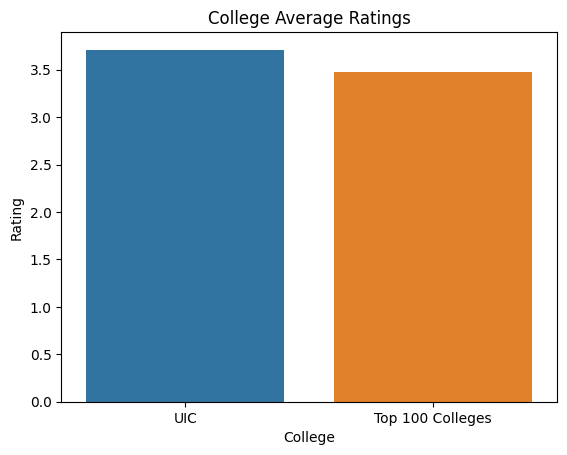

In [23]:
# College Average Ratings
sns.barplot(data=all_ratings, x='College', y='Rating').set(title="College Average Ratings")

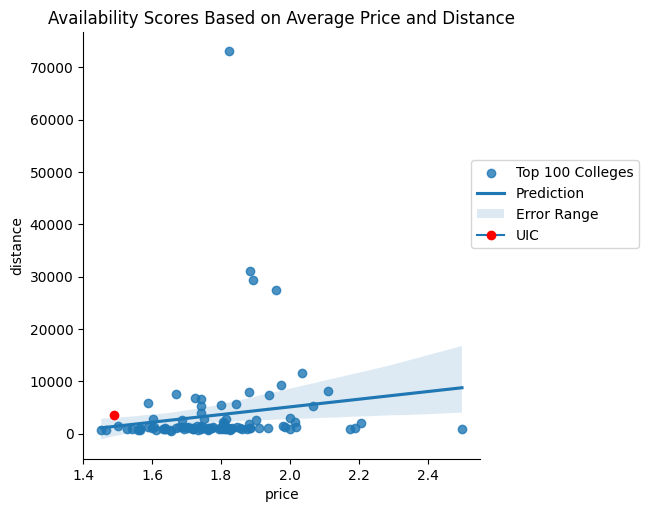

In [68]:
# Availability Scores based on Average Price and Distance
    # Availability = distance + price. Lower distance and price means higher availability since these restaurants are easier to access from a distance and financial perspective.
sns.lmplot(data=df3, x="price", y="distance", legend=False, palette="Blues")
plt.plot(1.49, 3543, marker="o", markersize=6, markeredgecolor="red", markerfacecolor="red")
plt.title("Availability Scores Based on Average Price and Distance")
plt.legend(labels=['Top 100 Colleges', 'Prediction', 'Error Range', 'UIC'], loc= "upper right", bbox_to_anchor=(1.4, 0.7), borderaxespad=0)

[Text(0.5, 1.0, 'Income/Price for UIC vs Top 100 Colleges')]

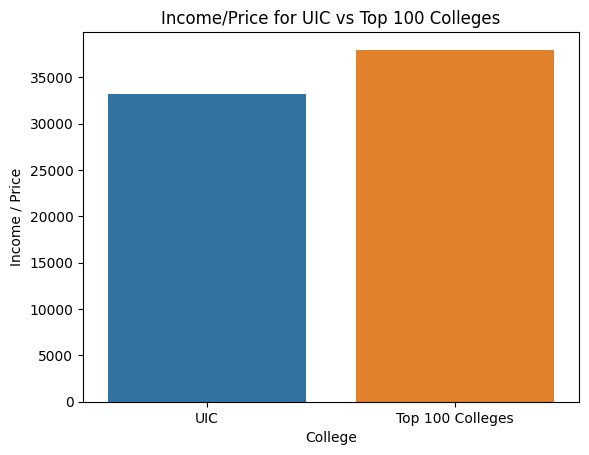

In [99]:
# Average income/Avg price vs college
sns.barplot(data=income_over_price_vs_college, x='College', y='Income / Price').set(title="Income/Price for UIC vs Top 100 Colleges")

# Machine Learning/Statistics

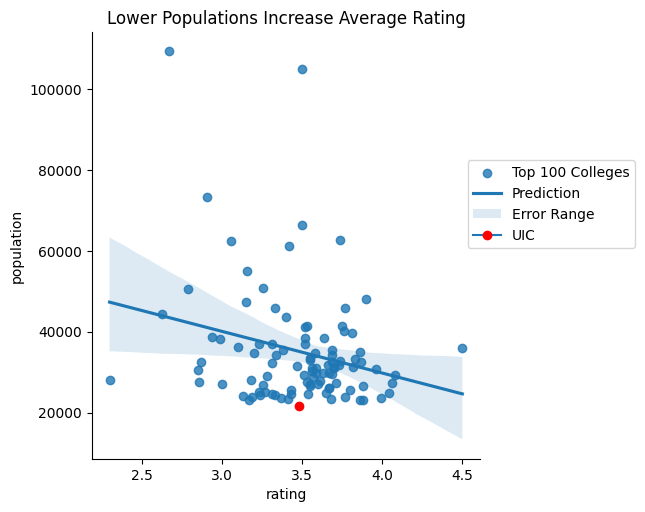

In [63]:
# Lower Populations Increase Average Rating
sns.lmplot(data=df3, x="rating", y="population", legend=False)
plt.plot(3.48, uic_data['latest.student.size'], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="red")
plt.title("Lower Populations Increase Average Rating")
plt.legend(labels=['Top 100 Colleges', 'Prediction', 'Error Range', 'UIC'], loc= "upper right", bbox_to_anchor=(1.4, 0.7), borderaxespad=0)

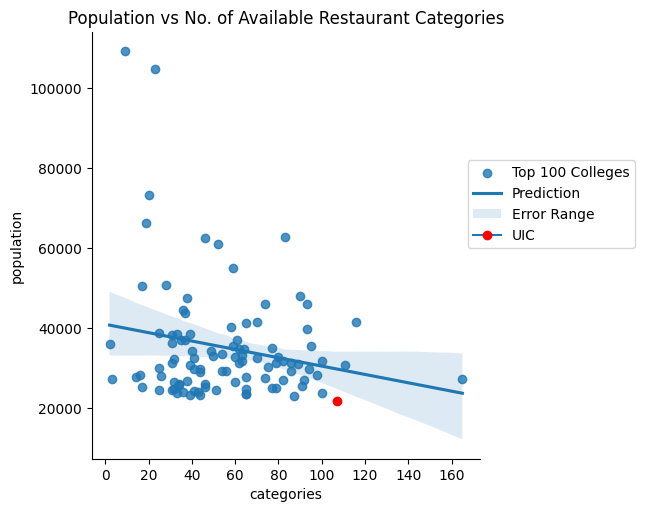

In [33]:
# Population vs Number of Available Restaurant Categories
sns.lmplot(data=df4, x="categories", y="population").set(title='Population vs No. of Available Restaurant Categories')
plt.plot(uic_unique_categories, uic_population, marker="o", markersize=6, markeredgecolor="red", markerfacecolor="red")
plt.legend(labels=['Top 100 Colleges', 'Prediction', 'Error Range', 'UIC'], loc= "upper right", bbox_to_anchor=(1.4, 0.7), borderaxespad=0)

# Results

### Topic
Restaurant Dining Assessment

### Description
For this project have used data science techniques to determine the quality of restaurant food around college campuses.

### Problem
To understand the current restaurant experience ratings across the top 100 college campuses. These ratings were also used to compare to specific campuses (for our report we used UIC). There were many questions to answer to solve this problem, including:
-Enjoyment of restaurants?
-Divesity of restaurants?
-Availability of restaurants?
-How do specific campuses like UIC compare?

### APIs / Data Collection
The tools we used for this project include:
College Scorecard API:
    -Used to gather data the data for the top 100 populated colleges
Google Maps API:
    - For college addresses
Yelp API:
    - Gather all restaurant information per college address

With these three API we collected the following data:
Each restaurant within a 1 mile radius of each college campus:
    - Restaurant name
    - Restaurant rating
    - Food prices
    - Distance

As you can imaging aggregating this data took a substantial amount of time (100s of Yelp API calls representing all the restaurants for each college campus) and thus would be difficult to send as a file.

In addtion to restaurant data, the data from each of the top 100 schools (based on population) included:
    - Student population
    - College address

### Visualizations
Working with the average ratings for UIC and the top 100 colleges based on population, we pulled data from the yelp API and retrieved the reviews of the nearest restaurants that are within a half a mile radius from the school. After cleaning and processing the data we can see that when we calculate the average ratings for UIC yelp reviews. UIC stands at a 3.71/5.0, meaning, UIC is above average which is good but not the best. In comparison to the top 100 colleges which scored a 3.48/5.0. There are many possible factors that can attribute to this such as proximity from school, price, and of course the quality of the food.

If we take a look at the availability score visualization, we can see that it is based on average price and average distance, this is how we defined availability. In our findings, we noticed that most restaurants average one to two dollar sign ratings according to yelp. This means, restaurants nearby colleges are fairly inexpensive. When we take UIC into account (red dot), we can see UIC price average is roughly 1.5 dollar signs and is less than 5,000 distance away from restaurants which puts UIC in the top percentile of schools with the highest availability

Our last visualization is the income/price visualization. This visualization shows the income to price metric of UIC vs the top 100 universities. We used income to price as a metric for the affordability of the restaurants for the university demographic. Income being the average family income of the students and price being the average price of the restaurants. It is important to note that the price is given as a score from 1 - 4, where 1 is least expensive and 4 is the most expensive. So with the income to price metric the higher the score the better the restaurants affordability for the students at the university and as you can see UIC falls below the average of the top 100 universities meaning our restaurants are not as affordable for our students.

### ML/Statisics Models
The first model we made for our ML analysis was an attempt to correlate population and average ratings for each college campus by using linear regression. With the top 100 colleges, we already have obtained a training set to work with. The test set we used for this analysis was UIC. Our hypothesis was that smaller colleges would have a smaller ranger of options but because of this the quality of each of these restaurants would be higher. However, the actual data pulled for UIC does not fit the prediciton line: despite having a smaller population, the ratings for all of the restaurants was average.

The next model was made to find a correlation between the population of schools and the number of restaurant categories available. Our hypothesis was that schools with a lower population will have a lower number of categories. We assumed that, in general, bigger schools will have more fast food and chain restaurants that are similar to one another to account for their big population. We did linear regression to rest the data of the top 100 schools and found that UIC stands well above average and does not fall within the prediciton curve; UIC has a great amount of diversity despite having a lower population.

### UIC Compared to Top 100

In our restaurant dining assessment of UIC, we determined that UIC's dining experience was above average compared to the top 100 college campuses by population. These were the final results based on our visualizations and anaylsis:
    - Ratings: Above Average
    - Availability: Above Average
    - Income to Price: Below Average
    - Pop/Avg Rating: Below Average
    - Diversity: Above Average

UIC is above average in comparison to the top universities yet lacks in affordability for our demographic, and due to our lower population we’re supposed to have higher average restaurant ratings when taking into account our schools relatively smaller population.

### Key Takeaways

Overall, from this assessment we learned how to aggregate data from multiple sources and make meaning out of it. This involved working with a lot of new information and APIs that our group was unfamiliar with. 

We also learned how to filter the data to suit our needs. For example, the Yelp API originally included businesses in the query and had to be filtered out to only include restaurants. The API also had a lot of different dictionary keys that we did not need and had to choose specific ones that we felt would make a good analysis. Lastly, we were able to visualize this aggregated data to prove how well UIC compared to other college campuses by showing visualiztions with statistical analysis.